In [8]:
%cd ..

c:\equivarianceWork\clifford-group-equivariant-neural-networks


In [42]:
import numpy as np
import matplotlib.pyplot as plt
plt.axis('equal')

import torch
torch.set_default_dtype(torch.float64)

from models.modules.fcgp import FullyConnectedSteerableGeometricProductLayer
from models.modules.gp import SteerableGeometricProductLayer
from models.modules.linear import MVLinear
from models.modules.mvsilu import MVSiLU
from models.modules.mvlayernorm import MVLayerNorm

from algebra.cliffordalgebra import CliffordAlgebra

In [110]:
algebra = CliffordAlgebra((1.,1., 1., -1.)) # "three consecutive basis 1-vectors squaring to 1, one squaring to -1"

looseBound = 10.

def simpleRotor(s, e12=0.,e13=0.,e14=0.,e23=0.,e24=0.,e34=0.):
    return \
        algebra.embed_grade( torch.tensor([0.5]), 0) + \
        algebra.embed_grade( torch.tensor([0.5,0.,0.,0.,0.,0.]), 2)
def make1Vec(a=0.,b=0.,c=0.,d=0.):
    return algebra.embed_grade( torch.tensor([a,b,c,d]), 1)

def makeRotPt(arr):
    return algebra.embed_grade( torch.tensor([1.,arr[0],arr[0],arr[1],arr[1],0.]), 2)
def makeScalePt(arr):
    return algebra.embed_grade( torch.tensor([0.,-arr[1],-arr[1],arr[0],arr[0],1.]), 2)
def rotPtToArr(rotPt):
    return [ (rotPt[6]+rotPt[7]) * 0.5 / rotPt[5], (rotPt[8]+rotPt[9]) * 0.5 / rotPt[5]]


def reverseMv(a):
    return torch.tensor([a[0],a[1],a[2],a[3],a[4],-a[5],-a[6],-a[7],-a[8],-a[9],-a[10],-a[11],-a[12],-a[13],-a[14],a[15]])
def sw(a,b):
    return algebra.geometric_product(algebra.geometric_product(a,b),reverseMv(a)) 

def generateRandomRotor():

    # TODO not homogeneous
    translationX = looseBound * (torch.rand(1)-0.5)
    translationY = looseBound * (torch.rand(1)-0.5)
    translation = simpleRotor(1., 0., translationX, translationX, translationY, translationY, 0.)

    angle = torch.rand(1) * np.pi
    rotPtX = looseBound * (torch.rand(1)-0.5)
    rotPtY = looseBound * (torch.rand(1)-0.5)
    rotation = algebra.embed_grade( torch.tensor([np.cos(angle)]), 0) + np.sin(angle) * makeRotPt([rotPtX,rotPtY])
    
    scaleFactor = torch.rand(1)
    scalePtX = looseBound * (torch.rand(1)-0.5)
    scalePtY = looseBound * (torch.rand(1)-0.5)
    scale = algebra.embed_grade( torch.tensor([np.cosh(scaleFactor)]), 0) + np.sinh(scaleFactor) * makeScalePt([scalePtX, scalePtY])

    return algebra.geometric_product(translation, algebra.geometric_product(rotation, scale))


# a = torch.tensor([0.,0.,1.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.])
# b = torch.tensor([0.,1.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.])

# algebra.geometric_product(a,b)

tensor([ 4.4409e-16,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         5.0000e-01, -4.7625e+00, -4.7625e+00,  2.5273e+00,  2.5273e+00,
         8.8818e-16,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         4.4964e-15])
tensor([ 4.4409e-16,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         5.0000e-01, -5.2456e+00, -5.2456e+00,  2.9442e+00,  2.9442e+00,
         1.3323e-15,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         4.4409e-15])
tensor([-4.4409e-16,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         5.0000e-01, -5.6624e+00, -5.6624e+00,  2.4611e+00,  2.4611e+00,
        -3.3307e-16,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.6368e-15])
tensor([-4.4409e-16,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         5.0000e-01, -5.1793e+00, -5.1793e+00,  2.0442e+00,  2.0442e+00,
        -4.4409e-16,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.6090e-15])


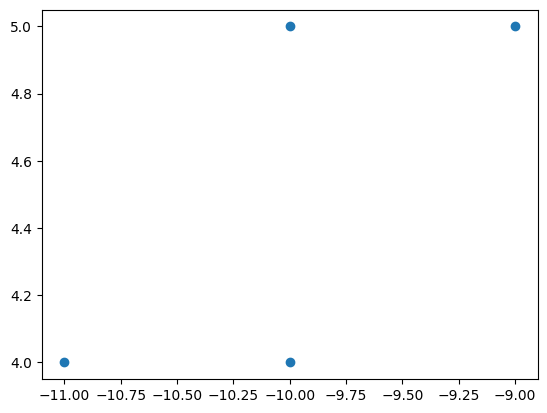

In [129]:
squareVerts = np.array([[-1,-1],[1,-1],[1,1],[-1,1]])

# print(rotPtToArr(makeRotPt([3.3,7.1])))

rotor = generateRandomRotor()

newVerts = np.array([[0,0],[0,0],[0,0],[0,0]])
for i in range(0,4):
    vert = squareVerts[i]

    makeRotPt(vert)

    newRotPt = sw(rotor, makeRotPt(vert))
    print(newRotPt)

    newVerts[i] = rotPtToArr(newRotPt)

plt.scatter(newVerts[:,0], newVerts[:,1])


## Project ideas
-Maybe use SGA

## Aesthetic preferences
Fuuuuuuuuck non-versors!!! Wanna stay in even/odd subalgebra, maybe even in the k-reflections
So you EITHER have a 2k-reflection as input and output OR a 2k+1-reflection, and all the way along the layers
And each layer composes you with another 2k-reflection, possibly acquired from exponentiating a bivector


Generate files, all in one folder. Named _rotated, _scaled, _translated
"Pictures" are just coordinates, separated by spaces with the points separated by line breaks. No boundaries, which is nice
Each pic has 4 vertices, that's all
Generate one "picture" of a square. Apply a random rotation/translation/scale to it
Generate again, add varying level of noise, do lots of random rotations and translations and scales